# Projekt Algorytmy Uczenia Maszynowego

## Wczytanie oraz wizualizacja zbioru danych  

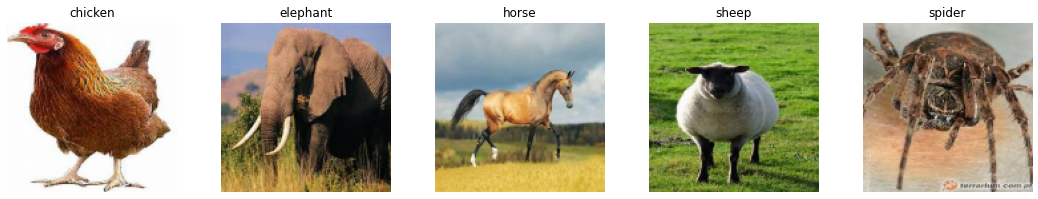

In [1]:
from skimage.io import imshow, imread_collection
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np


def load_images(class_name, values, labels):
    path_to_image = 'raw-img/'
    postfix = '/*.jpeg'
    image_size = (128,128)
    for image in imread_collection(path_to_image + class_name + postfix):
        values.append(resize(image, image_size))
        labels.append(class_name)

def create_data_set():
    class_names = ['spider', 'horse', 'elephant', 'chicken', 'sheep']
    values = []
    labels = []
    for class_name in class_names:
        load_images(class_name, values, labels)

    return np.array(values), np.array(labels)

def plot_data_set(x, y, unique_labels):
    fig, axes = plt.subplots(1, len(unique_labels))
    fig.set_size_inches(15,4)
    fig.tight_layout()

    for ax, label in zip(axes, unique_labels):
        ax.imshow(x[np.where(y == label)[0][0]])
        ax.axis('off')
        ax.set_title(label)

x, y = create_data_set()
unique_labels = np.unique(y)

plot_data_set(x, y, unique_labels)


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=15)

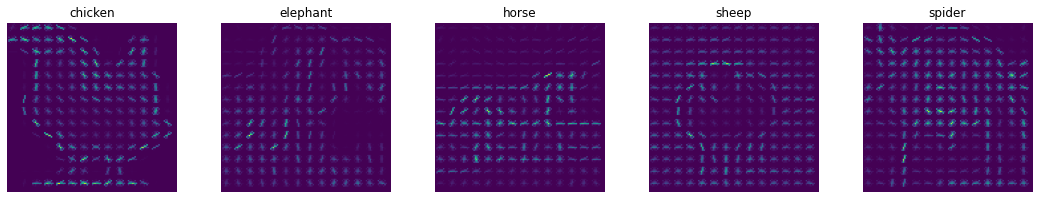

In [2]:
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

def extract_hog_features(values, orientation = 9, pixels_per_cell=(9,9), cells_per_block=(4,4)):
    scalify = StandardScaler()
    return scalify.fit_transform(
        np.array([ hog(img, orientations=orientation, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, channel_axis=-1) for img in values ]))

def plot_hog_features_extraction(x, y, unique_labels, orientation = 9, pixels_per_cell=(9,9), cells_per_block=(4,4)):
    fig, axes = plt.subplots(1, len(unique_labels))
    fig.set_size_inches(15,4)
    fig.tight_layout()

    for ax, label in zip(axes, unique_labels):
        fd, img = hog(
            image=x[np.where(y == label)[0][0]],
            orientations=orientation,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            visualize=True,
            channel_axis=-1) 
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(label)

hog_train = extract_hog_features(x_train)

plot_hog_features_extraction(x, y, unique_labels)

# Wykorzystanie maszyny wektorów nośnych(SVM) w zadaniu klasyfikacji

In [3]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm

svm_svc = svm.SVC()
svm_svc.fit(hog_train, y_train)

hog_test = extract_hog_features(x_test)
labels_predicted = svm_svc.predict(hog_test)

print('SVM percentage correct: ', 100*np.sum(labels_predicted == y_test)/len(y_test))
print(classification_report(y_test, labels_predicted))
print(confusion_matrix(y_test, labels_predicted))


SVM percentage correct:  85.52036199095022
              precision    recall  f1-score   support

     chicken       0.94      0.85      0.89        52
    elephant       0.96      0.70      0.81        33
       horse       0.71      0.88      0.79        48
       sheep       0.82      0.80      0.81        41
      spider       0.92      1.00      0.96        47

    accuracy                           0.86       221
   macro avg       0.87      0.84      0.85       221
weighted avg       0.87      0.86      0.86       221

[[44  0  2  4  2]
 [ 1 23  7  2  0]
 [ 2  1 42  1  2]
 [ 0  0  8 33  0]
 [ 0  0  0  0 47]]


# Wykorzystanie perceptronu wielowarstwowego(MLP) w zadaniu klasyfikacji

In [4]:
from sklearn.neural_network import MLPClassifier

mlp_classifier = MLPClassifier(alpha=1, max_iter=1000)
mlp_classifier.fit(hog_train, y_train)

labels_predicted_mlp = mlp_classifier.predict(hog_test)

print('MLP percentage correct: ', 100*np.sum(labels_predicted_mlp == y_test)/len(y_test))
print(classification_report(y_test, labels_predicted_mlp))
print(confusion_matrix(y_test, labels_predicted_mlp))

MLP percentage correct:  82.3529411764706
              precision    recall  f1-score   support

     chicken       0.90      0.83      0.86        52
    elephant       0.69      0.73      0.71        33
       horse       0.78      0.79      0.78        48
       sheep       0.84      0.78      0.81        41
      spider       0.88      0.96      0.92        47

    accuracy                           0.82       221
   macro avg       0.82      0.82      0.82       221
weighted avg       0.83      0.82      0.82       221

[[43  0  1  3  5]
 [ 3 24  4  2  0]
 [ 2  7 38  1  0]
 [ 0  2  6 32  1]
 [ 0  2  0  0 45]]


# Wykorzystanie k najbliższych sąsiadów(KNN) w zadaniu klasyfikacji

In [5]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=1)

neigh.fit(hog_train, y_train)

labels_predicted_neigh = neigh.predict(hog_test)

print('Knn percentage correct: ', 100*np.sum(labels_predicted_neigh == y_test)/len(y_test))
print(classification_report(y_test, labels_predicted_neigh))
print(confusion_matrix(y_test, labels_predicted_neigh))


Knn percentage correct:  65.15837104072398
              precision    recall  f1-score   support

     chicken       0.66      0.77      0.71        52
    elephant       1.00      0.33      0.50        33
       horse       0.83      0.52      0.64        48
       sheep       0.44      0.83      0.57        41
      spider       0.83      0.72      0.77        47

    accuracy                           0.65       221
   macro avg       0.75      0.64      0.64       221
weighted avg       0.74      0.65      0.65       221

[[40  0  0  9  3]
 [ 5 11  1 15  1]
 [ 5  0 25 18  0]
 [ 2  0  2 34  3]
 [ 9  0  2  2 34]]
